In [11]:
# Load required libraries
library(qiime2R)
library(phyloseq)
library(microViz)

# Load libraries for network analysis
library(SpiecEasi)      # packageVersion("SpiecEasi")
library(igraph)         # packageVersion("igraph")
library(ggraph)
library(influenceR)     # packageVersion("influenceR")
library(tidygraph)
library(tidyverse)      # packageVersion("tidyverse")
library(ggrepel)
library(ggpubr)
library(svglite)

# Check package versions (optional)
packageVersion("SpiecEasi")
packageVersion("igraph")
packageVersion("influenceR")
packageVersion("tidyverse")


[1] ‘1.1.3’

[1] ‘2.1.1’

[1] ‘0.1.5’

[1] ‘2.0.0’

In [3]:
setwd("/Users/stephanie.rosales/Documents/Tissueloss/EPA2")

In [4]:
#read metadata file and set factor order
meta = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/metadata/meta_EPA2.csv",
               header=TRUE, row.names=1)
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))
head(meta, n=2)
dim(meta)


#read ASV table
ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/merged_tables_BacArc_fill_EPA2.qza")
ASV_table <- ASV_qza$data
head(ASV_table, n=2)
dim(ASV_table)

taxa_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/tax_EPA2.qza")
taxa_table <- taxa_qza$data
taxa_table <- taxa_qza$data %>%
as_tibble() %>% 
#select(-Confidence) %>% 
separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
arrange(Feature.ID) %>%
mutate(ASVs =paste('ASV',1:n(), sep = "_")) %>%
column_to_rownames("Feature.ID")%>%
as.matrix()

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


[1] 360  45

,R1.1.W,R1.10.W,R1.11.W,R1.12.W,R1.13.W,R1.14.W,R1.15.W,R1.16.W,R1.17.W,R1.18.W,⋯,GR.SINT.En4,GR.SINT.En5,GR.SINT.En6,TP.DLAB.En1,TP.DLAB.En2,TP.DLAB.En3,TP.DLAB.En4,TP.DLAB.En5,TP.DLAB.En6,TP.DSTO.En1
72caa013fe7649c65ffe72138ff7dfd1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2b248f10cca3c82a2640506132f9c869,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11756  1109

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 103262 rows [1, 2, 3, 7,
8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, ...].”


In [5]:
ps = phyloseq(otu_table(ASV_table, taxa_are_rows=TRUE), 
               sample_data(meta),
tax_table(taxa_table))
ps %>% tax_fix()

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 360 samples ]
sample_data() Sample Data:       [ 360 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

In [6]:
# Subset samples healthy and then by species
ps_AH <- subset_samples(ps, Sample.Type=="Healthy")
ps_AH
# Subset samples for Sediment type
ps_Sediment <- subset_samples(ps, subset = sample_data(ps)$Type == "Sediment")
ps_Sediment
ps_Water <- subset_samples(ps, subset = sample_data(ps)$Type == "Water")
ps_Water 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 117 samples ]
sample_data() Sample Data:       [ 117 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 90 samples ]
sample_data() Sample Data:       [ 90 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 96 samples ]
sample_data() Sample Data:       [ 96 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

## Filter random forest data

In [7]:
## Filter ASVS that did not contribute to the RF model (i.e, importance =0)

rf_coral = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/coral_Rf.csv",
               header=TRUE, row.names=1) 

rf_coral_filtered <- rf_coral %>%
  filter(all != 0.0000000000 & all > 0)

# Remove the prefix 'X' from row names
rownames(rf_coral_filtered) <- gsub("^X", "", rownames(rf_coral_filtered))


# Display the first few rows of the new dataframe
head(rf_coral_filtered)

# Get the dimensions of the new dataframe
dim(rf_coral_filtered)


rf_sed = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/sed_Rf.csv",
               header=TRUE, row.names=1)
rf_sed_filtered= rf_sed%>%
  filter(all > 0)

# Remove the prefix 'X' from row names
rownames(rf_sed_filtered) <- gsub("^X", "", rownames(rf_sed_filtered))


# Display the first few rows of the new dataframe
head(rf_sed_filtered)

# Get the dimensions of the new dataframe
dim(rf_sed_filtered)

rf_wat = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/wat_Rf.csv",
               header=TRUE, row.names=1)

rf_wat_filtered=rf_wat %>%
  filter(all != 0.0000000000 & all > 0)

# Remove the prefix 'X' from row names
rownames(rf_wat_filtered) <- gsub("^X", "", rownames(rf_wat_filtered))


# Display the first few rows of the new dataframe
head(rf_wat_filtered)

# Get the dimensions of the new dataframe
dim(rf_wat_filtered)


,all,Vulnerable,Epidemic,Endemic
,<dbl>,<dbl>,<dbl>,<dbl>
4af34e31f4f29f5372246db273985eb8,0.0001679929,-6.035798e-18,-0.00129442,0.002265235
3da2ced63ab908b7a3be96b147e3004a,0.0003418803,4.027084e-03,0.00000000,0.000000000
f71e8be5ffefd9c56af594b2a42ea17c,0.0001709402,0.000000e+00,0.00129442,0.000000000
f5d7ec18156c74db93a21bd1261e8f78,0.0010300875,4.027084e-03,0.00129442,0.003397852
572f06c3cc65f3e95ef57f05acfea074,0.0003418803,0.000000e+00,0.00000000,0.002265235
168e60bb8b9ed33dad140c574171e8dc,0.0006852599,8.054168e-03,-0.00129442,0.001132617


[1] 358   4

,all,Vulnerable,Epidemic,Endemic
,<dbl>,<dbl>,<dbl>,<dbl>
a5d038ae417969dc3a845563786a4f4e,0.0002222222,0.000000000,-6.035798e-18,0.001812188
1605894602fa8e58e38a4e19a5f3425e,0.0002247191,0.000000000,0.000000e+00,0.001812188
8c96c96991ec5317be412beb5ea7f048,0.0008965517,0.005436564,1.812188e-03,0.000000000
69b6e618b8ec979d0e10aa0258efeca1,0.0029165248,0.016309691,3.624376e-03,0.003624376
7c06eeebc8353fd35c1b598420da3c12,0.0004444444,0.000000000,3.624376e-03,0.000000000
bc9a91ae7bf9b04e0714309f211b4c12,0.0002222222,0.001812188,0.000000e+00,0.000000000


[1] 488   4

,all,Vulnerable,Epidemic,Endemic
,<dbl>,<dbl>,<dbl>,<dbl>
4af34e31f4f29f5372246db273985eb8,0.0002105263,0.000000000,0.001812188,0.000000000
516a7dfb3358a03ad54608b2bfe54ded,0.0008465845,0.003020313,0.001812188,0.001812188
6d5a010f72f3f1199973aaa7ec9c4164,0.0008465845,0.003020313,0.003624376,0.000000000
69b6e618b8ec979d0e10aa0258efeca1,0.0018904909,0.001510157,0.014497503,0.000000000
7c06eeebc8353fd35c1b598420da3c12,0.0004210526,0.001510157,0.000000000,0.001812188
f5b2e70217cc44b43a423ebc8609a4af,0.0046188455,0.024162505,0.003624376,0.007248752


[1] 249   4

In [8]:
# select importance values that do not equal to zero in each site status

# Vector of column names to select
column_names <- c("Vulnerable", "Epidemic", "Endemic")

# Create an empty list to store the results
selected_columns <- list()

# Loop over the column names
for (col in column_names) {
  selected_columns[[col]] <- rf_coral_filtered %>%
    select(all_of(col)) %>% 
    arrange(desc(get(col))) %>%
    filter(get(col) > 0)
}




# Access the individual dataframes
rf_coral_vul <- selected_columns[["Vulnerable"]]
rf_coral_epi <- selected_columns[["Epidemic"]]
rf_coral_end <- selected_columns[["Endemic"]]

In [9]:
# select importance values that do not equal to zero in each site status


# Vector of column names to select
column_names <- c("Vulnerable", "Epidemic", "Endemic")

# Create an empty list to store the results
selected_columns <- list()

# Loop over the column names
for (col in column_names) {
  selected_columns[[col]] <- rf_sed_filtered %>%
    select(all_of(col))  %>% 
    arrange(desc(get(col))) %>%
    filter(get(col) > 0)
}


# Access the individual dataframes
rf_sed_vul <- selected_columns[["Vulnerable"]]
rf_sed_epi <- selected_columns[["Epidemic"]]
rf_sed_end <- selected_columns[["Endemic"]]



# Vector of column names to select
column_names <- c("Vulnerable", "Epidemic", "Endemic")

# Create an empty list to store the results
selected_columns <- list()

# Loop over the column names
for (col in column_names) {
  selected_columns[[col]] <- rf_wat_filtered %>%
    select(all_of(col))  %>% 
    arrange(desc(get(col))) %>%
    filter(get(col) >0)
}


# Access the individual dataframes
rf_wat_vul <- selected_columns[["Vulnerable"]]
rf_wat_epi <- selected_columns[["Epidemic"]]
rf_wat_end <- selected_columns[["Endemic"]]


In [10]:
# view each filtered list
vul_rf=rownames(rf_coral_vul) 
head(vul_rf)

epi_rf=rownames(rf_coral_epi) 
head(epi_rf)

end_rf=rownames(rf_coral_end) 
head(end_rf)


vul_sed_rf=rownames(rf_sed_vul) 
head(vul_sed_rf)

epi_sed_rf=rownames(rf_sed_epi) 
head(epi_sed_rf)

end_sed_rf=rownames(rf_sed_end) 
head(end_sed_rf)

vul_wat_rf=rownames(rf_wat_vul) 
head(vul_wat_rf)

epi_wat_rf=rownames(rf_wat_epi) 
head(epi_wat_rf)

end_wat_rf=rownames(rf_wat_end) 
head(end_wat_rf)


[1] "a5f208587e914e3c16310ef23c43bf87" "f47ce36f26232249e2ff2e488ba48bd0"
[3] "0920dcf0f62fb2b3ab9e32f1c4edec37" "faf1029d37956293b35d5c395a5297c1"
[5] "c16867ce7333b2d66e679f20c672b760" "fae58f96e2b2cb6910a2ada15c399b8e"

[1] "6d691235fdd09c3d204e499279d21406" "b8a5a874a00188de53bdd033791f917f"
[3] "76c75b6950ce069329a6c41d2c7527ed" "c16867ce7333b2d66e679f20c672b760"
[5] "3a5bed6f33492b43dbe33e2aefdc8e36" "e8260b1c0d85771b2cd89c293b7bddd0"

[1] "c16867ce7333b2d66e679f20c672b760" "f47ce36f26232249e2ff2e488ba48bd0"
[3] "3a5bed6f33492b43dbe33e2aefdc8e36" "2a92aa5f76bd13c49f995d4d7efa8cdc"
[5] "36c2a6ea002e715e20e3198c6f5def2b" "0920dcf0f62fb2b3ab9e32f1c4edec37"

[1] "a5fb9e2a180664a8c07645fdeb14099b" "a9a516691d10b9beb2649fa7d5782c36"
[3] "46cc8c873f9df000886f7dd97dd4b940" "fe144cd1c37a7ee4dbf77d6320e03669"
[5] "d99bee5f8478fe1760d0b3cf5e6183bc" "3a2ee79463550d3ca46aee721deea8d5"

[1] "bd53e2483c985a090089d93fc039c4ac" "93d599229f1b55f21eec84519bd4807f"
[3] "aac3fed77594bf011ae74840d1c7d22c" "62c6643ae1fdca670946784775723656"
[5] "99d3e2836fc1b032fd0ab0ee411a31eb" "674ada4cf67c5df711f938ed439cd1dc"

[1] "62c6643ae1fdca670946784775723656" "73deff5c5ffd78ea98ad2aa8304c94b3"
[3] "30034694309aad8d9fce419a0e14ed8a" "77698bb44fb8aca834066fff2d645cc1"
[5] "a51038fbb80698b8000037d489b8acec" "2897fd828b450125499092ae41d1b139"

[1] "a51038fbb80698b8000037d489b8acec" "57371e5644fa2cc11934909026c8e908"
[3] "b47d2421437e0c941114025e7dc183b4" "faf1029d37956293b35d5c395a5297c1"
[5] "f1a91c3d582018429dc42003b6f88ac4" "f5b2e70217cc44b43a423ebc8609a4af"

[1] "6939bd3f23555d5130dcf8c233c9450b" "e9c6bebb09f862b76f5853ea328fe31d"
[3] "6d691235fdd09c3d204e499279d21406" "3ee2e430d29fe718a63944d48f67640a"
[5] "2ac0e6fa85039f2f0ead04c6d2f09887" "497c46891c51c921fef8fb232995193f"

[1] "35eada3386f22f193f98be8c0b6d88c8" "206cac6b16f0f9bce4318f43c3d86345"
[3] "bc61e8b42af604e9c8858af057bfece9" "f1a91c3d582018429dc42003b6f88ac4"
[5] "db00a098f2f716d6174cdc4c60cedd6b" "7cbd1b00383a66b179cd6849ddabd0d2"

In [96]:

ps_AH_vu <- subset_samples(ps_AH, Site.Status=="Vulnerable") #Subset coral samples by site status

allTaxa = taxa_names(ps_AH_vu)  #select any taxa that had importance values >0 
allTaxa <- allTaxa[(allTaxa %in% vul_rf)]
ps_AH_vu_rf = prune_taxa(allTaxa, ps_AH_vu)
ps_AH_vu_rf
ps_AH_vu_rf = filter_taxa(ps_AH_vu_rf, function(x) sum(x > 0) > (0.00*length(x)), TRUE) # remove taxa that was a zero in abundance 
ps_AH_vu_rf 



ps_AH_epi <- subset_samples(ps_AH, Site.Status=="Epidemic")  #Subset coral samples by site status
allTaxa = taxa_names(ps_AH_epi)
allTaxa <- allTaxa[(allTaxa %in% epi_rf)]
ps_AH_epi_rf = prune_taxa(allTaxa, ps_AH_epi)
ps_AH_epi_rf
ps_AH_epi_rf = filter_taxa(ps_AH_epi_rf, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_AH_epi_rf 



ps_AH_end <- subset_samples(ps_AH, Site.Status=="Endemic")  #Subset coral samples by site status

allTaxa = taxa_names(ps_AH_end)
allTaxa <- allTaxa[(allTaxa %in% end_rf)]
ps_AH_end_rf = prune_taxa(allTaxa, ps_AH_end)
ps_AH_end_rf                           
ps_AH_end_rf = filter_taxa(ps_AH_end_rf, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_AH_end_rf 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 246 taxa and 27 samples ]
sample_data() Sample Data:       [ 27 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 246 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 211 taxa and 27 samples ]
sample_data() Sample Data:       [ 27 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 211 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 163 taxa and 42 samples ]
sample_data() Sample Data:       [ 42 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 163 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 161 taxa and 42 samples ]
sample_data() Sample Data:       [ 42 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 161 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 193 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 193 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 156 taxa and 48 samples ]
sample_data() Sample Data:       [ 48 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 156 taxa by 9 taxonomic ranks ]

In [97]:
# edit taxa matrix
taxa_df=as.data.frame(taxa_table) %>%
rownames_to_column("Feature.ID")%>%
rename(name=Feature.ID)
head(taxa_df)


rf_coral_df=rf_coral_filtered %>%
rownames_to_column("Feature.ID")%>%
rename(name=Feature.ID)
head(rf_coral_df)



rf_sed_df=rf_sed_filtered %>%
rownames_to_column("Feature.ID")%>%
rename(name=Feature.ID)
head(rf_sed_df)


rf_wat_df=rf_wat_filtered %>%
rownames_to_column("Feature.ID")%>%
rename(name=Feature.ID)
head(rf_wat_df)

,name,Kingdom,Phylum,Class,Order,Family,Genus,Species,Confidence,ASVs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,000003941bdff03b9dae68c9b7c5b7fc,d__Bacteria,p__Patescibacteria,c__Microgenomatia,o__Candidatus_Woesebacteria,f__Candidatus_Woesebacteria,g__Candidatus_Woesebacteria,NA,0.9713588,ASV_1
2,000009ca71fbef3a1702de6130f0b041,d__Bacteria,NA,NA,NA,NA,NA,NA,0.9965483,ASV_2
3,0000b84a296311cfe214483f9e2bfe28,d__Bacteria,p__Firmicutes,c__Clostridia,o__Christensenellales,f__Christensenellaceae,g__Christensenellaceae_R-7_group,NA,0.9431272,ASV_3
4,0000d1a50f0c9ae122d1b45df38c4638,d__Bacteria,p__Marinimicrobia_(SAR406_clade),c__Marinimicrobia_(SAR406_clade),o__Marinimicrobia_(SAR406_clade),f__Marinimicrobia_(SAR406_clade),g__Marinimicrobia_(SAR406_clade),s__unidentified_marine,0.9956728,ASV_4
5,0000f9a9a96f81bcfc9ab4393bf33e0e,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Stappiaceae,g__Stappiaceae,s__uncultured_bacterium,0.9999716,ASV_5
6,000100649fabaa9a585bd387e00611e5,d__Bacteria,p__Verrucomicrobiota,c__Chlamydiae,o__Chlamydiales,f__Simkaniaceae,g__uncultured,s__uncultured_Chlamydiales,0.7885016,ASV_6


,name,all,Vulnerable,Epidemic,Endemic
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,4af34e31f4f29f5372246db273985eb8,0.0001679929,-6.035798e-18,-0.00129442,0.002265235
2,3da2ced63ab908b7a3be96b147e3004a,0.0003418803,4.027084e-03,0.00000000,0.000000000
3,f71e8be5ffefd9c56af594b2a42ea17c,0.0001709402,0.000000e+00,0.00129442,0.000000000
4,f5d7ec18156c74db93a21bd1261e8f78,0.0010300875,4.027084e-03,0.00129442,0.003397852
5,572f06c3cc65f3e95ef57f05acfea074,0.0003418803,0.000000e+00,0.00000000,0.002265235
6,168e60bb8b9ed33dad140c574171e8dc,0.0006852599,8.054168e-03,-0.00129442,0.001132617


,name,all,Vulnerable,Epidemic,Endemic
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,a5d038ae417969dc3a845563786a4f4e,0.0002222222,0.000000000,-6.035798e-18,0.001812188
2,1605894602fa8e58e38a4e19a5f3425e,0.0002247191,0.000000000,0.000000e+00,0.001812188
3,8c96c96991ec5317be412beb5ea7f048,0.0008965517,0.005436564,1.812188e-03,0.000000000
4,69b6e618b8ec979d0e10aa0258efeca1,0.0029165248,0.016309691,3.624376e-03,0.003624376
5,7c06eeebc8353fd35c1b598420da3c12,0.0004444444,0.000000000,3.624376e-03,0.000000000
6,bc9a91ae7bf9b04e0714309f211b4c12,0.0002222222,0.001812188,0.000000e+00,0.000000000


,name,all,Vulnerable,Epidemic,Endemic
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,4af34e31f4f29f5372246db273985eb8,0.0002105263,0.000000000,0.001812188,0.000000000
2,516a7dfb3358a03ad54608b2bfe54ded,0.0008465845,0.003020313,0.001812188,0.001812188
3,6d5a010f72f3f1199973aaa7ec9c4164,0.0008465845,0.003020313,0.003624376,0.000000000
4,69b6e618b8ec979d0e10aa0258efeca1,0.0018904909,0.001510157,0.014497503,0.000000000
5,7c06eeebc8353fd35c1b598420da3c12,0.0004210526,0.001510157,0.000000000,0.001812188
6,f5b2e70217cc44b43a423ebc8609a4af,0.0046188455,0.024162505,0.003624376,0.007248752


### Coral networks

In [98]:

# Perform SPIEC_EASI on vulnerable coral
AH_vu_rf <- ps_AH_vu_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_AH_vu <- adj2igraph(getRefit(AH_vu_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_AH_vu_rf)))

tbl_AH_vu=as_tbl_graph(ig_AH_vu)
tbl_AH_vu

Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



# A tbl_graph: 211 nodes and 442 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 211 × 1 (active)
   name                            
   <chr>                           
 1 f5d7ec18156c74db93a21bd1261e8f78
 2 168e60bb8b9ed33dad140c574171e8dc
 3 f8198e3bdcea5dd4fe0813a5c09c36e8
 4 69b6e618b8ec979d0e10aa0258efeca1
 5 7c06eeebc8353fd35c1b598420da3c12
 6 00c8d36c9c818222ab961581f7b76389
 7 6b61a9a86c11784473de889b540dcd27
 8 3e1fd4e161279f0057744b2ec51d3e3b
 9 e8dffbce4fe2d6ff88ee7a514d0f8a0b
10 ffb065c084d24e7f77995ec7258cb076
# ℹ 201 more rows
#
# Edge Data: 442 × 3
   from    to weight
  <int> <int>  <dbl>
1     1   143      1
2     1   178      1
3     2    10      1
# ℹ 439 more rows

In [99]:
# Perform SPIEC_EASI on epidemic coral
AH_epi_rf <- ps_AH_epi_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_AH_epi <- adj2igraph(getRefit(AH_epi_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_AH_epi_rf)))

tbl_AH_epi=as_tbl_graph(ig_AH_epi)
ig_AH_epi

Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



IGRAPH d47db02 UNW- 144 226 -- 
+ attr: name (v/c), weight (e/n)
+ edges from d47db02 (vertex names):
[1] f71e8be5ffefd9c56af594b2a42ea17c--8edc438ed8c25107c4d0682063f1590a
[2] f71e8be5ffefd9c56af594b2a42ea17c--d1bba5d48eb1f1935e4876b2796660bc
[3] f71e8be5ffefd9c56af594b2a42ea17c--6fb535390a68cdb8703ede690c3c21ea
[4] f71e8be5ffefd9c56af594b2a42ea17c--b8627b47a5855dda2aa3858f3cc73410
[5] f5d7ec18156c74db93a21bd1261e8f78--a9522d64f8f84f5ee6aebce3ec1f412b
[6] f8198e3bdcea5dd4fe0813a5c09c36e8--e4304c9496921fcf8a88c1ef30dfd0eb
[7] f8198e3bdcea5dd4fe0813a5c09c36e8--1b21d2b71f96b4a59b392aee9aa1d655
[8] 7c06eeebc8353fd35c1b598420da3c12--179787ca41a0364caa75647870a9cd3d
+ ... omitted several edges

In [100]:
# Perform SPIEC_EASI on endemic coral
AH_end_rf <- ps_AH_end_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_AH_end <- adj2igraph(getRefit(AH_end_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_AH_end_rf)))

tbl_AH_end=as_tbl_graph(ig_AH_end)
tbl_AH_end

Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



# A tbl_graph: 122 nodes and 133 edges
#
# An undirected simple graph with 8 components
#
# Node Data: 122 × 1 (active)
   name                            
   <chr>                           
 1 4af34e31f4f29f5372246db273985eb8
 2 572f06c3cc65f3e95ef57f05acfea074
 3 168e60bb8b9ed33dad140c574171e8dc
 4 f8198e3bdcea5dd4fe0813a5c09c36e8
 5 7c06eeebc8353fd35c1b598420da3c12
 6 674ada4cf67c5df711f938ed439cd1dc
 7 c7a5fc8b60f7a299061fd5110888705a
 8 985fa4d3eea20f3e012e41447ea018f1
 9 25b16c2d8347323de231a354760ffa74
10 c43c425b27aff58fb1227673f21d9403
# ℹ 112 more rows
#
# Edge Data: 133 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    35      1
2     2     9      1
3     2    50      1
# ℹ 130 more rows

In [101]:
#Combine network output with metadata

#rf_coral=rf_coral %>% rownames_to_column("name")

node_AH_vu=tbl_AH_vu %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
left_join(rf_coral_df)  %>% 
mutate(
    diameter=graph_diameter(),
alpha_centrality = centrality_alpha(),
    hcluster=node_rank_hclust(),
    graph_m = node_effective_network_size(),
    neighbors = centrality_degree(),
         group = group_infomap(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 5),
Site.Status="1.Vulnerable",
Type="Coral"
) %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
filter(!edge_is_loop()) %>%
  mutate(centrality = centrality_edge_betweenness())

node_AH_vu

Joining with `by = join_by(name)`
Joining with `by = join_by(name)`


# A tbl_graph: 211 nodes and 442 edges
#
# An undirected simple graph with 1 component
#
# Edge Data: 442 × 4 (active)
    from    to weight centrality
   <int> <int>  <dbl>      <dbl>
 1     1   143      1       61.6
 2     1   178      1      179. 
 3     2    10      1      264. 
 4     2    28      1      131. 
 5     2    40      1      121. 
 6     2   193      1      524. 
 7     3    35      1      211. 
 8     3    37      1      165. 
 9     3   117      1      418. 
10     3   152      1      113. 
# ℹ 432 more rows
#
# Node Data: 211 × 24
  name  Kingdom Phylum Class Order Family Genus Species Confidence ASVs      all
  <chr> <chr>   <chr>  <chr> <chr> <chr>  <chr> <chr>   <chr>      <chr>   <dbl>
1 f5d7… d__Bac… " p__… " c_… " o_…  NA     NA   NA      0.9716776  ASV_… 1.03e-3
2 168e… d__Bac… " p__… " c_… " o_… " f__…  NA   NA      0.9998140  ASV_… 6.85e-4
3 f819… d__Bac… " p__… " c_… " o_… " f__… " g_… NA      0.9976656  ASV_… 1.90e-3
# ℹ 208 more rows
# ℹ 13 more variable

In [102]:
#Combine network output with metadata

node_AH_epi=tbl_AH_epi %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
left_join(rf_coral_df)  %>% 
mutate(
     diameter=graph_diameter(),
alpha_centrality = centrality_alpha(),
    hcluster=node_rank_hclust(),
    graph_m = node_effective_network_size(),
    neighbors = centrality_degree(),
         group = group_infomap(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 5),
Site.Status="2.Epidemic",
Type="Coral") %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
  filter(!edge_is_loop()) %>%
  mutate(centrality = centrality_edge_betweenness())

node_AH_epi

Joining with `by = join_by(name)`
Joining with `by = join_by(name)`


# A tbl_graph: 144 nodes and 226 edges
#
# An undirected simple graph with 1 component
#
# Edge Data: 226 × 4 (active)
    from    to weight centrality
   <int> <int>  <dbl>      <dbl>
 1     1    32      1      233. 
 2     1    53      1      259. 
 3     1   101      1       76.9
 4     1   103      1      143  
 5     2     5      1      143  
 6     3    95      1      143  
 7     3   118      1      284  
 8     4    16      1      142. 
 9     4    36      1      407. 
10     4    65      1       76.4
# ℹ 216 more rows
#
# Node Data: 144 × 24
  name  Kingdom Phylum Class Order Family Genus Species Confidence ASVs      all
  <chr> <chr>   <chr>  <chr> <chr> <chr>  <chr> <chr>   <chr>      <chr>   <dbl>
1 f71e… d__Bac… " p__… " c_… " o_… " f__…  NA   NA      0.9628604  ASV_… 1.71e-4
2 f5d7… d__Bac… " p__… " c_… " o_…  NA     NA   NA      0.9716776  ASV_… 1.03e-3
3 f819… d__Bac… " p__… " c_… " o_… " f__… " g_… NA      0.9976656  ASV_… 1.90e-3
# ℹ 141 more rows
# ℹ 13 more variable

In [103]:
tbl_AH_end

# A tbl_graph: 122 nodes and 133 edges
#
# An undirected simple graph with 8 components
#
# Node Data: 122 × 1 (active)
   name                            
   <chr>                           
 1 4af34e31f4f29f5372246db273985eb8
 2 572f06c3cc65f3e95ef57f05acfea074
 3 168e60bb8b9ed33dad140c574171e8dc
 4 f8198e3bdcea5dd4fe0813a5c09c36e8
 5 7c06eeebc8353fd35c1b598420da3c12
 6 674ada4cf67c5df711f938ed439cd1dc
 7 c7a5fc8b60f7a299061fd5110888705a
 8 985fa4d3eea20f3e012e41447ea018f1
 9 25b16c2d8347323de231a354760ffa74
10 c43c425b27aff58fb1227673f21d9403
# ℹ 112 more rows
#
# Edge Data: 133 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    35      1
2     2     9      1
3     2    50      1
# ℹ 130 more rows

In [104]:
#Combine network output with metadata

node_AH_end= tbl_AH_end %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
left_join(rf_coral_df)  %>% 
mutate(
   diameter=graph_diameter(),
alpha_centrality = centrality_alpha(alpha = 0.85),
    #hcluster=node_rank_hclust(),
    graph_m = node_effective_network_size(),
    neighbors = centrality_degree(),
         group = group_infomap(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 5),
Site.Status="3.Endemic",
Type="Coral") %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
 filter(!edge_is_loop()) %>%
  mutate(centrality = centrality_edge_betweenness())

node_AH_end

Joining with `by = join_by(name)`
Joining with `by = join_by(name)`


# A tbl_graph: 122 nodes and 133 edges
#
# An undirected simple graph with 8 components
#
# Edge Data: 133 × 4 (active)
    from    to weight centrality
   <int> <int>  <dbl>      <dbl>
 1     1    35      1      101  
 2     2     9      1      101  
 3     2    50      1       98.5
 4     2   115      1      274. 
 5     3   110      1      101  
 6     4    25      1      101  
 7     5    52      1      291. 
 8     5    88      1      215. 
 9     6    16      1      661. 
10     6    70      1      101  
# ℹ 123 more rows
#
# Node Data: 122 × 23
  name  Kingdom Phylum Class Order Family Genus Species Confidence ASVs      all
  <chr> <chr>   <chr>  <chr> <chr> <chr>  <chr> <chr>   <chr>      <chr>   <dbl>
1 4af3… d__Bac… " p__… " c_… " o_… " f__… " g_… " s__u… 0.7535425  ASV_… 1.68e-4
2 572f… d__Bac… " p__… " c_… " o_… " f__… " g_… " s__u… 0.7008424  ASV_… 3.42e-4
3 168e… d__Bac… " p__… " c_… " o_… " f__…  NA    NA     0.9998140  ASV_… 6.85e-4
# ℹ 119 more rows
# ℹ 12 more variabl

In [105]:
#Combine graphs for corals
combo = node_AH_epi %>% bind_graphs(node_AH_end)
combo = combo %>% bind_graphs(node_AH_vu)

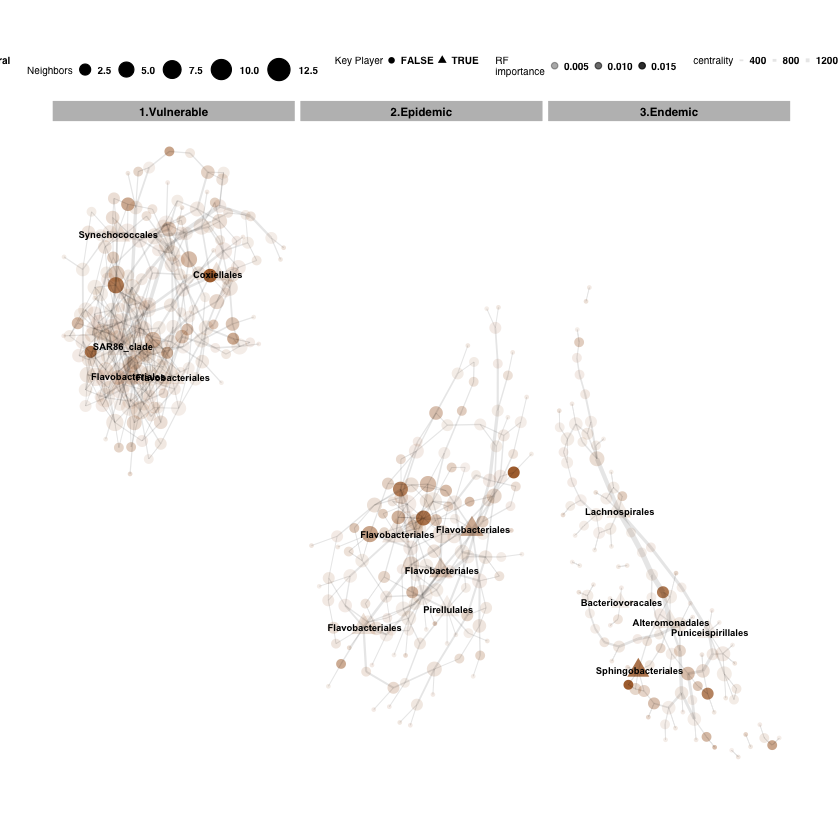

In [256]:
set.seed(1011)
combo = node_AH_epi %>% bind_graphs(node_AH_end)
combo = combo %>% bind_graphs(node_AH_vu)

fig_nw_ah=combo %>%
  activate(nodes) %>%
  # Uncomment the next line if you want to filter by moduleMemberCorr
  # filter(moduleMemberCorr > 0.2) %>%
  filter(!node_is_isolated()) %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "c__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "o__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "g__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "Rhodobacterales", replacement = "Rhodobacterales\n") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "Actinomarinales", replacement = "Actinomarinales\n") %>%
  ggraph(layout = "nicely") + 
  geom_node_point(aes(size =  neighbors, color = Type, shape = keyplayer,  alpha = all)) + 
  geom_node_text(aes(label = ifelse(keyplayer == "TRUE", as.character(Order), "")), size = 2, fontface = "bold", repel = FALSE) +
  geom_edge_link(aes(width = centrality), alpha = 0.1) + 
  scale_edge_width_continuous(range = c(0.2, 1.5)) +
  theme_graph(base_size = 7, border = FALSE, foreground = 'Grey', fg_text_colour = 'black', base_family = 'Helvetica') +
  theme(
    legend.spacing = unit(0.11, "cm"),
    legend.position = "top", 
    legend.box = "horizontal",
    legend.key.size = unit(0.2, 'lines'),
    legend.text = element_text(size = 6, face = "bold"),
    legend.title = element_text(size = 6),
    legend.key.height = unit(0.1, "line"),
    strip.text = element_text(size = 7, face = "bold")
  ) +
  guides(
    shape = guide_legend(order = 2, nrow = 1), 
    color = guide_legend(order = 1, nrow = 1),
    size = guide_legend(order = 2, nrow = 1),
    centrality = guide_legend(order = 1, nrow = 1)
  ) +
  scale_color_manual(values = c("#AD6F3B")) +
  facet_graph(~Site.Status, scales = "free") +
  scale_fill_identity() +
  scale_edge_alpha(guide = 'none') +
  labs(color = "", size = "Neighbors", shape = "Key Player", 
      alpha="RF\nimportance")

fig_nw_ah

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Supp_Fig3.svg",
     width = 6.5, height = 8 , units = "in", dpi=300)

### Sediment pre-process  

In [107]:
# List of site statuses and corresponding row names
site_statuses <- c("Vulnerable", "Epidemic", "Endemic")
rf_names <- list(vul_sed_rf, epi_sed_rf, end_sed_rf)
ps_sed_rf_list <- list()

# Loop over the site statuses
for (i in 1:length(site_statuses)) {
  site_status <- site_statuses[i]
  rf_name <- rf_names[[i]]
  
  # Subset samples by site status
  ps_Sediment_subset <- subset_samples(ps_Sediment, Site.Status == site_status)
  print(ps_Sediment_subset) # Optional: print the subset
  
  # Get taxa names and filter based on rf_name
  allTaxa <- taxa_names(ps_Sediment_subset)
  allTaxa <- allTaxa[(allTaxa %in% rf_name)]
  
  # Prune taxa
  ps_sed_rf <- prune_taxa(allTaxa, ps_Sediment_subset)
  
  # Store the result in a list
  ps_sed_rf_list[[site_status]] <- ps_sed_rf
}

# Access the individual ps_AH_rf objects
ps_sed_vu_rf <- ps_sed_rf_list[["Vulnerable"]]
ps_sed_epi_rf <- ps_sed_rf_list[["Epidemic"]]
ps_sed_end_rf <- ps_sed_rf_list[["Endemic"]]

# Print the results
print(ps_sed_vu_rf)
print(ps_sed_epi_rf)
print(ps_sed_end_rf)


ps_sed_vu_rf = filter_taxa(ps_sed_vu_rf, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_sed_vu_rf
ps_sed_epi_rf = filter_taxa(ps_sed_epi_rf, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_sed_epi_rf
ps_sed_end_rf = filter_taxa(ps_sed_end_rf, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_sed_end_rf                          

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 159 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 159 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level obje

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 135 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 135 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 302 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 302 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 149 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 149 taxa by 9 taxonomic ranks ]

### Sediment networks

In [108]:
# Perform SPIEC_EASI on sediment epidemic samples
sed_epi_rf <- ps_sed_epi_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_sed_epi <- adj2igraph(getRefit(sed_epi_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_sed_epi_rf)))


Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



In [109]:
# Perform SPIEC_EASI on endemic sediment samples
sed_end_rf <- ps_sed_end_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_sed_end <- adj2igraph(getRefit(sed_end_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_sed_end_rf)))

Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



In [110]:
# Perform SPIEC_EASI on vulnerable sediment samples
sed_vul_rf <- ps_sed_vu_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_sed_vul <- adj2igraph(getRefit(sed_vul_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_sed_vu_rf)))

Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



In [111]:
# convert from if to table graphs
tbl_sed_epi=as_tbl_graph(ig_sed_epi)
tbl_sed_epi

tbl_sed_vu=as_tbl_graph(ig_sed_vul)
tbl_sed_vu

tbl_sed_end=as_tbl_graph(ig_sed_end)
tbl_sed_end

# A tbl_graph: 295 nodes and 589 edges
#
# An undirected simple graph with 1 component
#
# Node Data: 295 × 1 (active)
   name                            
   <chr>                           
 1 8c96c96991ec5317be412beb5ea7f048
 2 69b6e618b8ec979d0e10aa0258efeca1
 3 7c06eeebc8353fd35c1b598420da3c12
 4 266fd1896c2a019e28cf3824b2cf4ba2
 5 a582799f01f0c4a1ee1daebdecdcb269
 6 0f66f030c32ff2bbbe6e1abde1b3a9f0
 7 fdfc787adf602eda601ef08bf6a9493b
 8 43308fd927768ade77d3355fa76d8475
 9 7cbb704965b9ef0d0331055827292f04
10 a9b28796f170997c01027c397bf35aa2
# ℹ 285 more rows
#
# Edge Data: 589 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    26      1
2     1    40      1
3     1    52      1
# ℹ 586 more rows

# A tbl_graph: 120 nodes and 167 edges
#
# An undirected simple graph with 4 components
#
# Node Data: 120 × 1 (active)
   name                            
   <chr>                           
 1 8c96c96991ec5317be412beb5ea7f048
 2 69b6e618b8ec979d0e10aa0258efeca1
 3 bc9a91ae7bf9b04e0714309f211b4c12
 4 6a2f9ed3328a9626f0871171ce809dd3
 5 266fd1896c2a019e28cf3824b2cf4ba2
 6 0f66f030c32ff2bbbe6e1abde1b3a9f0
 7 28612edb306e8f9d2b9658b8b269e764
 8 3a2ac066cf517d2e8509666307cf84f5
 9 50f83531b7fc31500d9d243c85ff8605
10 6d6b964317095273b937d91ba6cd4ca7
# ℹ 110 more rows
#
# Edge Data: 167 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    16      1
2     1    25      1
3     1    32      1
# ℹ 164 more rows

# A tbl_graph: 53 nodes and 39 edges
#
# An unrooted forest with 14 trees
#
# Node Data: 53 × 1 (active)
   name                            
   <chr>                           
 1 a5d038ae417969dc3a845563786a4f4e
 2 69b6e618b8ec979d0e10aa0258efeca1
 3 266fd1896c2a019e28cf3824b2cf4ba2
 4 3a2ac066cf517d2e8509666307cf84f5
 5 907f79d96440b6c0da99f57c5a0d5aea
 6 e3ca182a0ea156aec58e100a0b9bfd31
 7 3125716495b179e779bacf48e367c283
 8 61dd26d8c6e1c80f0e30029aa6490c67
 9 dae8e27d8ff3f87822abd70aaa9fd4a2
10 3daf4215c9f16eb2c53926669cbd9032
# ℹ 43 more rows
#
# Edge Data: 39 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    17      1
2     1    35      1
3     1    41      1
# ℹ 36 more rows

In [112]:
# vulnerable sediments
node_sed_vu=tbl_sed_vu %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
left_join(rf_sed_df)  %>% 
mutate(
   diameter=graph_diameter(),
alpha_centrality = centrality_alpha(alpha = 0.85),
    graph_m = node_effective_network_size(),
    neighbors = centrality_degree(),
         group = group_infomap(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 5),
Site.Status="1.Vulnerable",
Type="Sediment") %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
 filter(!edge_is_loop()) %>%
  mutate(centrality = centrality_edge_betweenness())

node_sed_vu

Joining with `by = join_by(name)`
Joining with `by = join_by(name)`


# A tbl_graph: 120 nodes and 167 edges
#
# An undirected simple graph with 4 components
#
# Edge Data: 167 × 4 (active)
    from    to weight centrality
   <int> <int>  <dbl>      <dbl>
 1     1    16      1       40.9
 2     1    25      1      127. 
 3     1    32      1      219. 
 4     2    47      1      111  
 5     3    57      1      609. 
 6     3    91      1      492. 
 7     3   105      1      287. 
 8     3   110      1      111  
 9     4    51      1      111  
10     5    45      1      155. 
# ℹ 157 more rows
#
# Node Data: 120 × 23
  name  Kingdom Phylum Class Order Family Genus Species Confidence ASVs      all
  <chr> <chr>   <chr>  <chr> <chr> <chr>  <chr> <chr>   <chr>      <chr>   <dbl>
1 8c96… d__Bac… " p__… " c_… " o_… " f__…  NA   NA      0.9556578  ASV_… 8.97e-4
2 69b6… d__Bac… " p__… " c_… " o_… " f__… " g_… NA      0.9983523  ASV_… 2.92e-3
3 bc9a… d__Bac… " p__… " c_… " o_… " f__… " g_… NA      0.9979374  ASV_… 2.22e-4
# ℹ 117 more rows
# ℹ 12 more variabl

In [113]:
# epidemic sediments
node_sed_epi=tbl_sed_epi %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
mutate(
   diameter=graph_diameter(),
alpha_centrality = centrality_alpha(),
    #hcluster=node_rank_hclust(),
    graph_m = node_effective_network_size(),
    neighbors = centrality_degree(),
         group = group_infomap(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 5),
Site.Status="2.Epidemic",
Type="Sediment") %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
 filter(!edge_is_loop()) %>%
  mutate(centrality = centrality_edge_betweenness())

node_sed_epi

Joining with `by = join_by(name)`


# A tbl_graph: 295 nodes and 589 edges
#
# An undirected simple graph with 1 component
#
# Edge Data: 589 × 4 (active)
    from    to weight centrality
   <int> <int>  <dbl>      <dbl>
 1     1    26      1      455. 
 2     1    40      1      243. 
 3     1    52      1      389. 
 4     1    81      1       37.4
 5     1   154      1      191. 
 6     1   186      1      401. 
 7     2    42      1      228. 
 8     2    46      1      350. 
 9     2   178      1       15  
10     2   180      1      291. 
# ℹ 579 more rows
#
# Node Data: 295 × 19
  name          Kingdom Phylum Class Order Family Genus Species Confidence ASVs 
  <chr>         <chr>   <chr>  <chr> <chr> <chr>  <chr> <chr>   <chr>      <chr>
1 8c96c96991ec… d__Bac… " p__… " c_… " o_… " f__…  NA    NA     0.9556578  ASV_…
2 69b6e618b8ec… d__Bac… " p__… " c_… " o_… " f__… " g_…  NA     0.9983523  ASV_…
3 7c06eeebc835… d__Bac… " p__… " c_… " o_… " f__… " g_… " s__u… 0.9834081  ASV_…
# ℹ 292 more rows
# ℹ 9 more variables

In [114]:
# endemic sediments
node_sed_end=tbl_sed_end %>% 
    activate(nodes) %>% 
left_join(taxa_df)  %>% 
left_join(rf_sed_df)  %>% 
mutate(
   diameter=graph_diameter(),
alpha_centrality = centrality_alpha(alpha = 0.85),
    #hcluster=node_rank_hclust(),
    graph_m = node_effective_network_size(),
    neighbors = centrality_degree(),
         group = group_infomap(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 5),
Site.Status="3.Endemic",
Type="Sediment") %>%
  activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
 filter(!edge_is_loop()) %>%
  mutate(centrality = centrality_edge_betweenness())

node_sed_end

Joining with `by = join_by(name)`
Joining with `by = join_by(name)`


# A tbl_graph: 53 nodes and 39 edges
#
# An unrooted forest with 14 trees
#
# Edge Data: 39 × 4 (active)
    from    to weight centrality
   <int> <int>  <dbl>      <dbl>
 1     1    17      1         72
 2     1    35      1         17
 3     1    41      1         56
 4     2    52      1          4
 5     3    20      1          1
 6     4    14      1          1
 7     5    17      1         17
 8     6    26      1         17
 9     7    33      1          2
10     8    42      1          1
# ℹ 29 more rows
#
# Node Data: 53 × 23
  name  Kingdom Phylum Class Order Family Genus Species Confidence ASVs      all
  <chr> <chr>   <chr>  <chr> <chr> <chr>  <chr> <chr>   <chr>      <chr>   <dbl>
1 a5d0… d__Bac… " p__… " c_… " o_… " f__… " g_… NA      0.9984613  ASV_… 2.22e-4
2 69b6… d__Bac… " p__… " c_… " o_… " f__… " g_… NA      0.9983523  ASV_… 2.92e-3
3 266f… d__Bac… " p__… " c_… " o_… " f__… " g_… NA      0.9525553  ASV_… 6.84e-4
# ℹ 50 more rows
# ℹ 12 more variables: Vulnerable <db

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


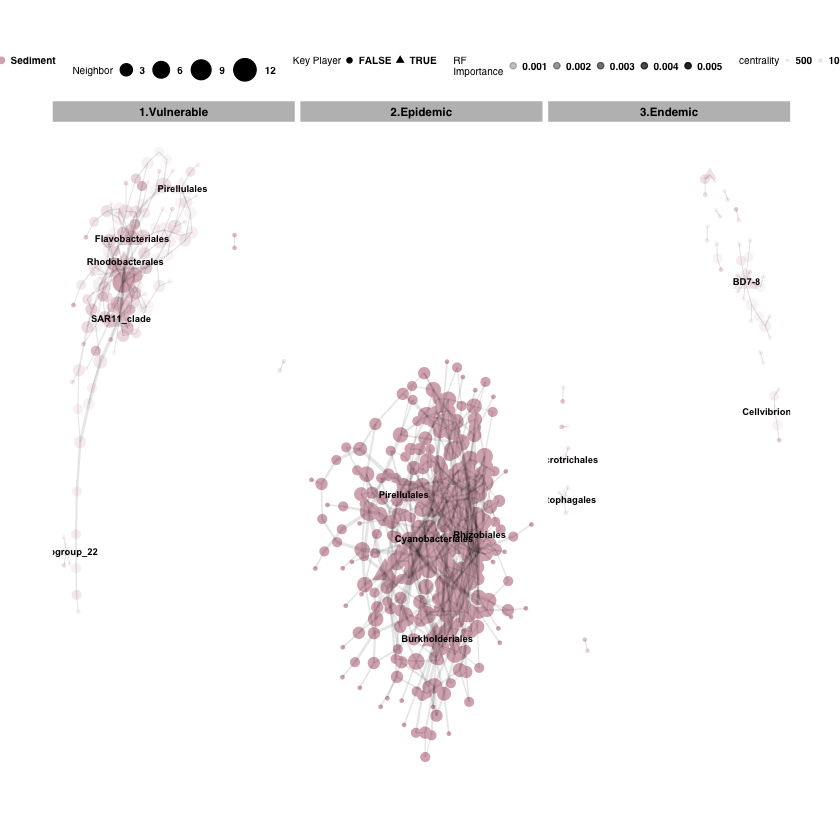

In [257]:
## Combine three disease stage into one graph
combo = node_sed_epi %>% bind_graphs(node_sed_end)
combo = combo %>% bind_graphs(node_sed_vu)

fig_nw_sed <- combo %>%
 activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
 filter(!edge_is_loop()) %>%
  activate(nodes) %>%
  # Uncomment the next line if you want to filter by moduleMemberCorr
  # filter(moduleMemberCorr > 0.2) %>%
  filter(!node_is_isolated()) %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "ASV_", replacement = "ASV") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "c__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "o__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "g__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "Rhodobacterales", replacement = "Rhodobacterales\n") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "Actinomarinales", replacement = "Actinomarinales\n") %>%
  ggraph(layout = "nicely") + 
  #geom_node_point(aes(size = all,  color = keyplayer), alpha = 0.20) + 
geom_node_point(aes(size =  neighbors, color = Type, shape = keyplayer,  alpha = all)) + 
  geom_node_text(aes(label = ifelse(keyplayer == "TRUE", as.character(Order), "")), size = 2, fontface = "bold", repel = FALSE) +
  geom_edge_link(aes(width = centrality), alpha = 0.1) + 
  scale_edge_width_continuous(range = c(0.2, 1.5)) +
  theme_graph(base_size = 7, border = FALSE, 
              foreground = 'grey', fg_text_colour = 'black', 
              base_family = 'Helvetica'
             ) +
  theme(
    legend.spacing = unit(0.11, "cm"),
    legend.position = "top", 
    legend.box = "horizontal",
    legend.key.size = unit(0.2, 'lines'),
    legend.text = element_text(size = 6, face = "bold"),
    legend.title = element_text(size = 6),
    legend.key.height = unit(0.1, "line"),
    strip.text = element_text(size = 7, face = "bold")
  ) +
  guides(
    shape = guide_legend(order = 2, nrow = 1), 
    color = guide_legend(order = 1, nrow = 1),
    size = guide_legend(order = 2, nrow = 1),
    centrality = guide_legend(order = 1, nrow = 1)
  ) +
# scale_color_manual(values = c("orange", "khaki1", "#CD9BCD", "gray80", "salmon", "Navy","#D14285", "#652926","#8569D5",
 #                 "#DA5724","#CD9BCD", "ivory4","#bf7f8f")) +
  scale_color_manual(values = c("#d8b2bc")) +
  facet_graph(~Site.Status, scales = "free") +
  scale_fill_identity() +
  scale_edge_alpha(guide = 'none') +
  labs(color = "", size = "Neighbor", shape = "Key Player",
      alpha="RF\nImportance")

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Supp_Fig5.svg",
     width = 6, height = 6.5 , units = "in", dpi=300)

fig_nw_sed

### Water pre-processing

In [116]:
# List of site statuses and corresponding row names
site_statuses <- c("Vulnerable", "Epidemic", "Endemic")
rf_names <- list(vul_wat_rf, epi_wat_rf, end_wat_rf)
ps_wat_rf_list <- list()

# Loop over the site statuses
for (i in 1:length(site_statuses)) {
  site_status <- site_statuses[i]
  rf_name <- rf_names[[i]]
  
  # Subset samples by site status
  ps_Water_subset <- subset_samples(ps_Water, Site.Status == site_status)
  print(ps_Water_subset) # Optional: print the subset
  
  # Get taxa names and filter based on rf_name
  allTaxa <- taxa_names(ps_Water_subset)
  allTaxa <- allTaxa[(allTaxa %in% rf_name)]
  
  # Prune taxa
  ps_wat_rf <- prune_taxa(allTaxa, ps_Water_subset)
  
  # Store the result in a list
  ps_wat_rf_list[[site_status]] <- ps_wat_rf
}

# Access the individual ps_AH_rf objects
ps_wat_vu_rf <- ps_wat_rf_list[["Vulnerable"]]
ps_wat_epi_rf <- ps_wat_rf_list[["Epidemic"]]
ps_wat_end_rf <- ps_wat_rf_list[["Endemic"]]

# Print the results
print(ps_wat_vu_rf)
print(ps_wat_epi_rf)
print(ps_wat_end_rf)


ps_wat_vu_rf = filter_taxa(ps_wat_vu_rf, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_wat_vu_rf
ps_wat_epi_rf = filter_taxa(ps_wat_epi_rf, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_wat_epi_rf
ps_wat_end_rf = filter_taxa(ps_wat_end_rf, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_wat_end_rf                          

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 162 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 162 taxa by 9 taxonomic ranks ]
phyloseq-class experiment-level obje

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 130 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 130 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 132 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 132 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 109 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 109 taxa by 9 taxonomic ranks ]

### Water networks 

In [117]:
# Perform SPIEC_EASI on sed epi
wat_epi_rf <- ps_wat_epi_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_wat_epi <- adj2igraph(getRefit(wat_epi_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_wat_epi_rf)))


Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



In [118]:
# Perform SPIEC_EASI on sed epi
wat_end_rf <- ps_wat_end_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_wat_end <- adj2igraph(getRefit(wat_end_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_wat_end_rf)))


Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



In [119]:
# Perform SPIEC_EASI on sed epi
wat_vu_rf <- ps_wat_vu_rf %>%
  spiec.easi(
    method = 'mb',
    lambda.min.ratio = 1e-3,
    nlambda = 20,
    icov.select.params = list(rep.num = 100, seed= 1001)
  )

#  Convert to igraph and network objects
ig_wat_vu <- adj2igraph(getRefit(wat_vu_rf), rmEmptyNodes = TRUE,
                           vertex.attr=list(name=taxa_names(ps_wat_vu_rf)))


Applying data transformations...

Selecting model with pulsar using stars...

Fitting final estimate with mb...

done



In [120]:
tbl_wat_epi=as_tbl_graph(ig_wat_epi)
tbl_wat_epi

tbl_wat_vu=as_tbl_graph(ig_wat_vu)
tbl_wat_vu

tbl_wat_end=as_tbl_graph(ig_wat_end)
tbl_wat_end

# A tbl_graph: 79 nodes and 108 edges
#
# An undirected simple graph with 6 components
#
# Node Data: 79 × 1 (active)
   name                            
   <chr>                           
 1 4af34e31f4f29f5372246db273985eb8
 2 6d5a010f72f3f1199973aaa7ec9c4164
 3 d83f29f1a140139899bdff5b62c9ba9b
 4 b8a5a874a00188de53bdd033791f917f
 5 649e8e5cbf452134d7fa0ba96f43d049
 6 c7a5fc8b60f7a299061fd5110888705a
 7 4fecaaeccfbce756e77b1936e8a7b6a6
 8 c43c425b27aff58fb1227673f21d9403
 9 70d9067f8151b247cd59344be44d442c
10 d577b2f12fb72afd3b809671869375ab
# ℹ 69 more rows
#
# Edge Data: 108 × 3
   from    to weight
  <int> <int>  <dbl>
1     1     3      1
2     2    68      1
3     4    47      1
# ℹ 105 more rows

# A tbl_graph: 119 nodes and 142 edges
#
# An undirected simple graph with 8 components
#
# Node Data: 119 × 1 (active)
   name                            
   <chr>                           
 1 516a7dfb3358a03ad54608b2bfe54ded
 2 6d5a010f72f3f1199973aaa7ec9c4164
 3 69b6e618b8ec979d0e10aa0258efeca1
 4 7c06eeebc8353fd35c1b598420da3c12
 5 f5b2e70217cc44b43a423ebc8609a4af
 6 e9d3cecf616591d9aba293e6809c9315
 7 dd0cee8b70bef379ded7cdd0c87e26d7
 8 b8a5a874a00188de53bdd033791f917f
 9 649e8e5cbf452134d7fa0ba96f43d049
10 5221ed6699eda411e4d274256746ad7a
# ℹ 109 more rows
#
# Edge Data: 142 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    89      1
2     1   110      1
3     2    13      1
# ℹ 139 more rows

# A tbl_graph: 74 nodes and 85 edges
#
# An undirected simple graph with 4 components
#
# Node Data: 74 × 1 (active)
   name                            
   <chr>                           
 1 7c06eeebc8353fd35c1b598420da3c12
 2 95543146385a09f852ff3ff3f9f67298
 3 bdfec2797dcf1ba0329ace875d2d5b4d
 4 70d9067f8151b247cd59344be44d442c
 5 4c5a87e6631d397c1ade0545063bc150
 6 f7e3fb70c3b0c0e8043b864876ae9c74
 7 a765495a981deabd2c70f9e666408aa3
 8 c464817f47c18d57283ed2bddce0e10a
 9 46f538e665fbc467469be7d13cdaa912
10 c70565b6fa4c8ab447fd3d843dd98072
# ℹ 64 more rows
#
# Edge Data: 85 × 3
   from    to weight
  <int> <int>  <dbl>
1     1    10      1
2     1    45      1
3     1    56      1
# ℹ 82 more rows

In [121]:
# List of site statuses and corresponding tbl_graph objects
site_statuses <- c(
    "1.Vulnerable", 
    "2.Epidemic", "3.Endemic")
tbl_wat_list <- list(
    tbl_wat_vu, 
    tbl_wat_epi, tbl_wat_end)
node_wat_list <- list()

# Loop over the site statuses and tbl_graph objects
for (i in 1:length(site_statuses)) {
  site_status <- site_statuses[i]
  tbl_wat <- tbl_wat_list[[i]]
  
  # Perform the operations on the tbl_graph object
  node_wat <- tbl_wat %>% 
    activate(nodes) %>% 
    left_join(taxa_df, by = "name") %>% 
    left_join(rf_wat_df) %>%
    mutate(
   diameter=graph_diameter(),
alpha_centrality = centrality_alpha(alpha = 0.85),
    #hcluster=node_rank_hclust(),
    graph_m = node_effective_network_size(),
    neighbors = centrality_degree(),
         group = group_infomap(),
         dist_to_center = node_distance_to(node_is_center()),
         keyplayer = node_is_keyplayer(k = 5),
      Site.Status = site_status,
      Type = "Water"
    ) %>%
    activate(edges) %>% 
    filter(!edge_is_multiple()) %>%
     filter(!edge_is_loop()) %>%
    mutate(centrality = centrality_edge_betweenness())
  
  # Store the result in a list
  node_wat_list[[site_status]] <- node_wat
}

# Access the individual node_wat objects
node_wat_vu <- node_wat_list[["1.Vulnerable"]]
node_wat_epi <- node_wat_list[["2.Epidemic"]]
node_wat_end <- node_wat_list[["3Endemic"]]

# Print the results
print(node_wat_vu)
print(node_wat_epi)
print(node_wat_end)


Joining with `by = join_by(name)`
Joining with `by = join_by(name)`
Joining with `by = join_by(name)`


# A tbl_graph: 119 nodes and 142 edges
#
# An undirected simple graph with 8 components
#
# Edge Data: 142 × 4 (active)
    from    to weight centrality
   <int> <int>  <dbl>      <dbl>
 1     1    89      1        1  
 2     1   110      1       13  
 3     2    13      1      107. 
 4     2    55      1       85.5
 5     2   104      1      133. 
 6     2   114      1       58.7
 7     3    34      1      702. 
 8     3    67      1      539. 
 9     3    90      1      492. 
10     3    91      1     1072  
# ℹ 132 more rows
#
# Node Data: 119 × 23
  name  Kingdom Phylum Class Order Family Genus Species Confidence ASVs      all
  <chr> <chr>   <chr>  <chr> <chr> <chr>  <chr> <chr>   <chr>      <chr>   <dbl>
1 516a… d__Bac… " p__… " c_… " o_… " f__… " g_…  NA     0.7697921  ASV_… 8.47e-4
2 6d5a… d__Bac… " p__… " c_… " o_… " f__… " g_… " s__u… 0.9213195  ASV_… 8.47e-4
3 69b6… d__Bac… " p__… " c_… " o_… " f__… " g_…  NA     0.9983523  ASV_… 1.89e-3
# ℹ 116 more rows
# ℹ 12 more variabl

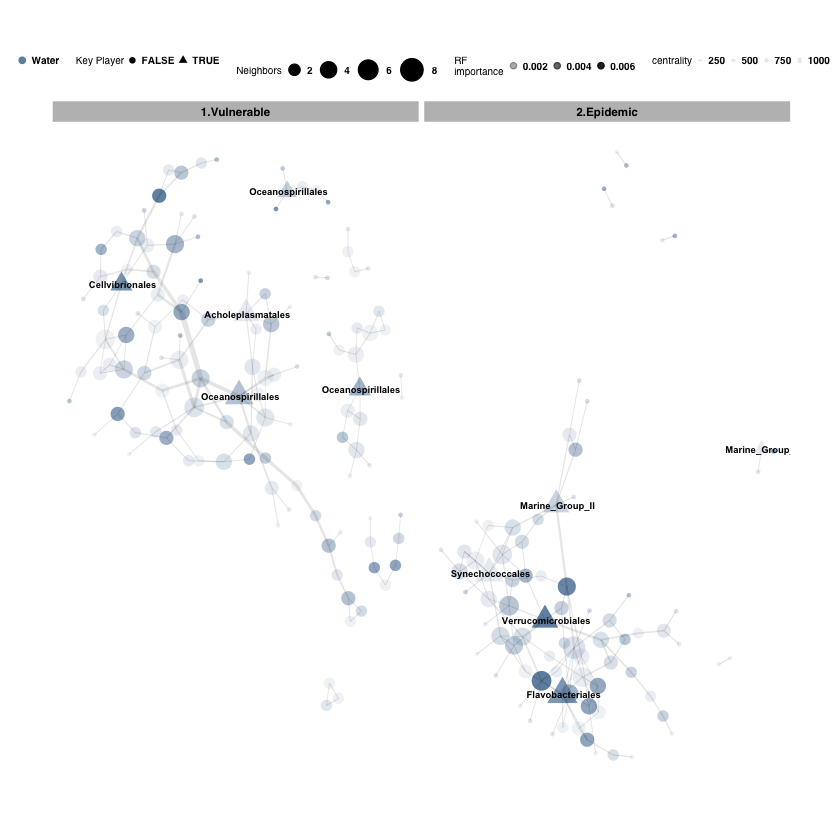

In [258]:
combo_w = node_wat_vu %>% bind_graphs(node_wat_epi) #%>% bind_graphs(node_wat_end)

fig_nw_wat=combo_w %>%
 activate(edges) %>% 
  filter(!edge_is_multiple()) %>%
 filter(!edge_is_loop()) %>%
  activate(nodes) %>%
  # Uncomment the next line if you want to filter by moduleMemberCorr
  # filter(moduleMemberCorr > 0.2) %>%
  filter(!node_is_isolated()) %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "c__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "o__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "g__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "Rhodobacterales", replacement = "Rhodobacterales\n") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "Actinomarinales", replacement = "Actinomarinales\n") %>%
  ggraph(layout = "nicely") + 
#"#6F8FAF"
  #geom_node_point(aes(size = all,  color = keyplayer), alpha = 0.20) + 
geom_node_point(aes(size =  neighbors, color = Type, shape = keyplayer,  alpha = all)) + 
  geom_node_text(aes(label = ifelse(keyplayer == "TRUE", as.character(Order), "")), size = 2, fontface = "bold", repel = FALSE) +
  geom_edge_link(aes(width = centrality), alpha = 0.1) + 
  scale_edge_width_continuous(range = c(0.2, 1.5)) +
  theme_graph(base_size = 7, border = FALSE, 
              foreground = 'Grey', fg_text_colour = 'black', 
              base_family = 'Helvetica'
             ) +
  theme(
    legend.spacing = unit(0.11, "cm"),
    legend.position = "top", 
    legend.box = "horizontal",
    legend.key.size = unit(0.2, 'lines'),
    legend.text = element_text(size = 6, face = "bold"),
    legend.title = element_text(size = 6),
    legend.key.height = unit(0.1, "line"),
    strip.text = element_text(size = 7, face = "bold")
  ) +
  guides(
    shape = guide_legend(order = 2, nrow = 1), 
    color = guide_legend(order = 1, nrow = 1),
    size = guide_legend(order = 2, nrow = 1),
    centrality = guide_legend(order = 1, nrow = 1)
  ) +
 scale_color_manual(values = c(
                              "#6F8FAF")) +
#"#800020","#AD6F3B", "#6F8FAF"
  facet_graph(~Site.Status, scales = "free") +
  scale_fill_identity() +
  scale_edge_alpha(guide = 'none') +
  labs(color = "", alpha = "RF\nimportance", size="Neighbors", shape = "Key Player")
fig_nw_wat



## Supplemental Figure 3

In [ ]:
combo = node_AH_epi %>% bind_graphs(node_AH_end)
combo = combo %>% bind_graphs(node_AH_vu) %>% bind_graphs(node_sed_vu) %>% bind_graphs(node_sed_epi) %>% bind_graphs(node_sed_end) %>% 
 bind_graphs(node_wat_epi) %>% bind_graphs(node_wat_vu)
#%>% bind_graphs(node_wat_end) 


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


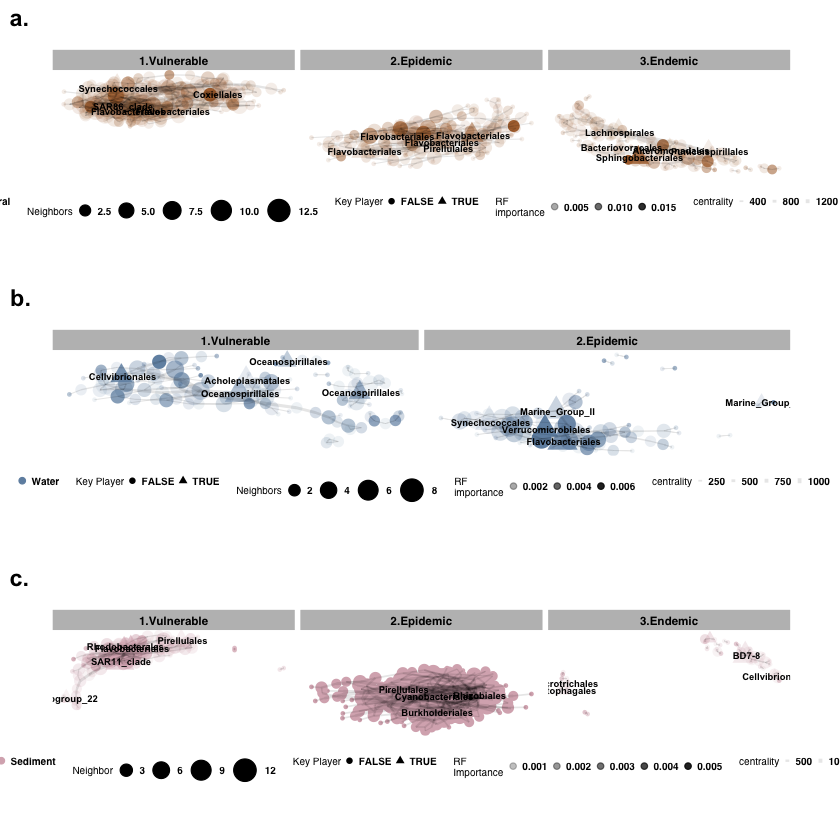

In [260]:
ggarrange(fig_nw_ah, fig_nw_wat, fig_nw_sed, nrow = 3, ncol=1, common.legend = FALSE, legend="bottom",
                           labels = c("a.","b.","c."))
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Supp_Fig4.svg",
     width = 6, height = 5 , units = "in", dpi=300)


## Figure 5

In [264]:
# make a dataframe with network metrics

combo = node_AH_epi %>% bind_graphs(node_AH_end)
combo = combo %>% bind_graphs(node_AH_vu) %>% bind_graphs(node_sed_vu) %>% bind_graphs(node_sed_epi) %>% bind_graphs(node_sed_end) %>% 
 bind_graphs(node_wat_epi) %>% bind_graphs(node_wat_vu)
#%>% bind_graphs(node_wat_end) 

long_combo =combo %>% 
  activate(nodes) %>%
mutate(Betweenness = centrality_betweenness()) %>% 
 as_tibble %>%
 select(diameter,
        Betweenness, 
        neighbors, Site.Status, Type, Order) %>% 
  pivot_longer(
    cols = c(
       Betweenness,
        diameter,  neighbors),
    names_to = "Attribute",
    values_to = "Value"
  )  
head(long_combo)

Site.Status,Type,Order,Attribute,Value
<chr>,<chr>,<chr>,<chr>,<dbl>
2.Epidemic,Coral,o__Chitinophagales,Betweenness,284.7421
2.Epidemic,Coral,o__Chitinophagales,diameter,13.0000
2.Epidemic,Coral,o__Chitinophagales,neighbors,4.0000
2.Epidemic,Coral,o__Bacteroidales,Betweenness,0.0000
2.Epidemic,Coral,o__Bacteroidales,diameter,13.0000
2.Epidemic,Coral,o__Bacteroidales,neighbors,1.0000


`summarise()` has grouped output by 'Site.Status', 'Type'. You can override
using the `.groups` argument.


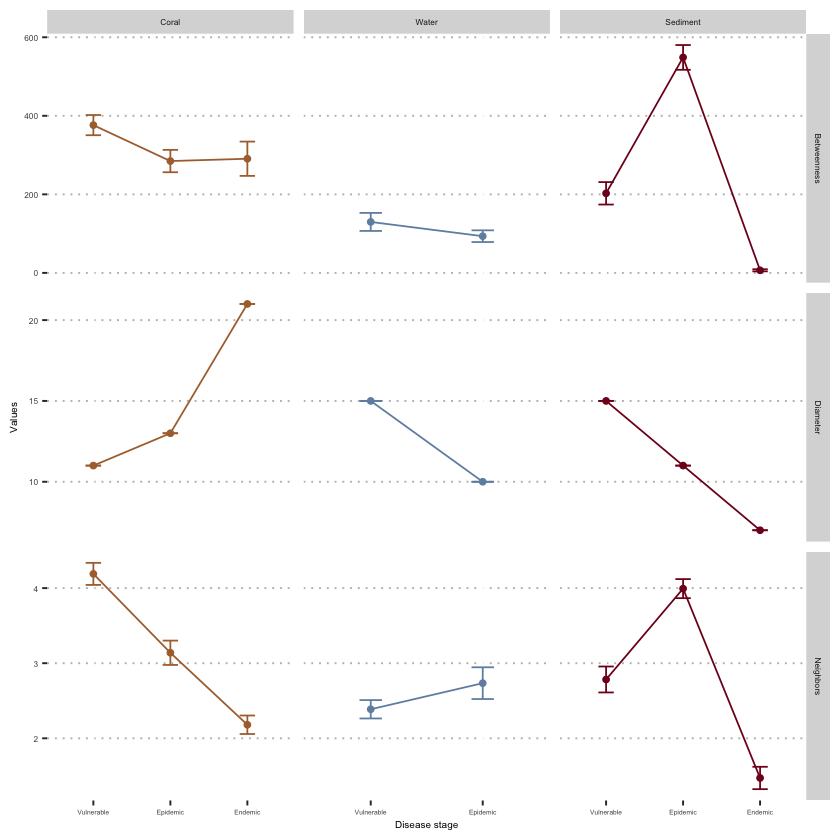

In [265]:
# Setting factor levels for Type
long_combo$Type <- factor(long_combo$Type, levels = c("Coral", "Water", "Sediment"))

# Define color palette
cbPalette <- c("#009E73", "#D55E00", "#696969")

# Function to calculate standard error of the mean (SEM)
sem <- function(x, na.rm = FALSE) {
  out <- sd(x, na.rm = na.rm) / sqrt(length(na.omit(x)))  # Use na.omit(x) to avoid NAs
  return(out)
}

# Define comparisons for statistical tests
my_comparisons <- list(c("1.Vulnerable", "2.Epidemic"), c("1.Vulnerable", "3.Endemic"),
                       c("3.Endemic", "2.Epidemic"))

# Data processing and plotting
long_combo %>%
  mutate(Attribute = str_replace_all(Attribute, "diameter", "Diameter")) %>%
  mutate(Attribute = str_replace_all(Attribute, "neighbors", "Neighbors")) %>%
  group_by(Site.Status, Type, Attribute) %>%
  summarize(
    graphm_m = mean(Value, na.rm = TRUE),  # Calculate mean of Value
    s = sem(Value, na.rm = TRUE)           # Calculate standard error
  ) %>%
  ggplot(aes(x = Site.Status, y = graphm_m, group = Type, color = Type)) +
  geom_point(stat = "identity") +        # Adding data points
  geom_line(stat = "identity") +         # Adding connecting lines
  geom_errorbar(aes(ymin = graphm_m - s, ymax = graphm_m + s), width = 0.2) + # Adding error bars
  scale_color_manual(values = c( "#AD6F3B", "#6F8FAF","#800020")) +
  theme_linedraw() +
  theme_pubclean() +
  facet_grid(Attribute ~ Type, scales = "free") +
  ylab("Values") +
  xlab("Disease stage") +
  theme(
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 6),
    axis.title.x = element_text(size = 6),
    axis.title.y = element_text(size = 6),
    axis.text.x = element_text(size = 4),
    axis.text.y = element_text(size = 5),
    strip.text = element_text(size = 5)
  ) +
scale_x_discrete(labels=c("1.Vulnerable" = "Vulnerable", "2.Epidemic" = "Epidemic",
                              "3.Endemic" = "Endemic")) +
  guides(fill = "none", color = "none")

ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Figure5.png",
     width = 4, height = 4 , units = "in", dpi=300)

Warning message:
“Removed 285 rows containing non-finite outside the scale range (`stat_qq()`).”
Warning message:
“Removed 285 rows containing non-finite outside the scale range
(`stat_qq_line()`).”


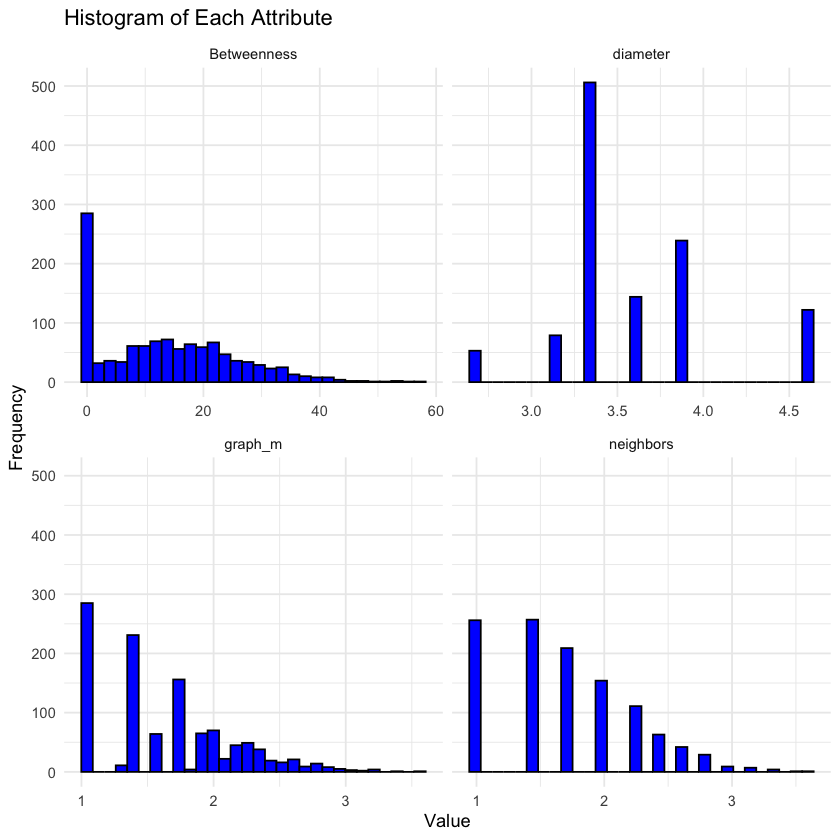

# A tibble: 4 × 2
  Attribute      p_value
  <chr>            <dbl>
1 Betweenness NaN       
2 diameter      3.33e-30
3 graph_m       9.93e-24
4 neighbors     9.20e-24


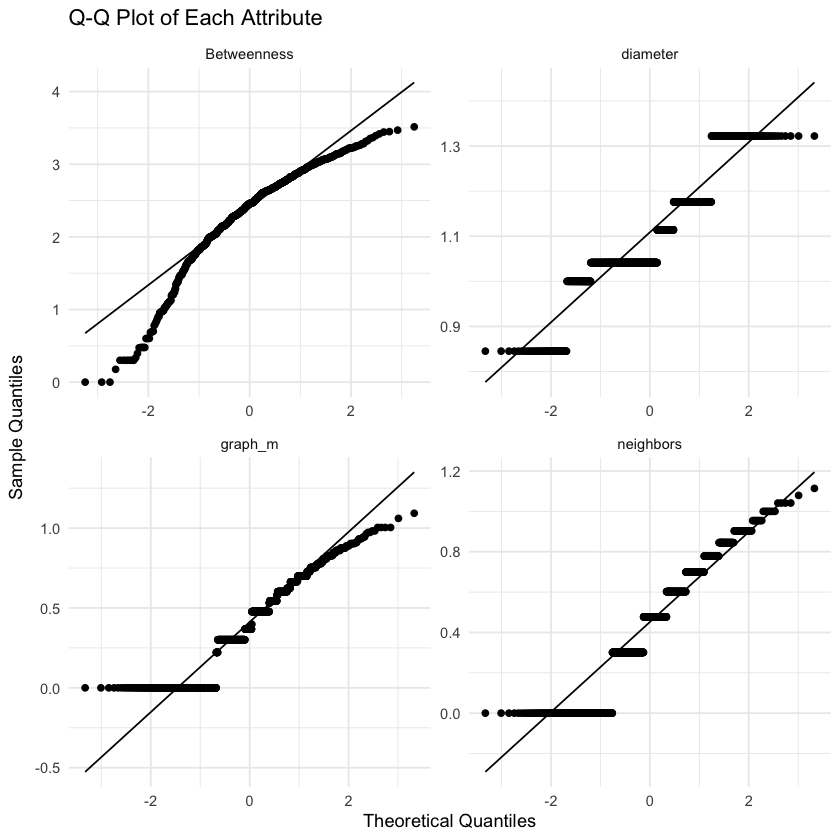

In [171]:
# test netowrk metrics for normality
# Create the long_combo data frame
long_combo <- combo %>% 
  activate(nodes) %>%
  mutate(Betweenness = centrality_betweenness()) %>%
  as_tibble() %>%
  select(diameter, Betweenness, graph_m, neighbors, Site.Status, Type) %>% 
  pivot_longer(
    cols = c(Betweenness, diameter, graph_m, neighbors),
    names_to = "Attribute",
    values_to = "Value"
  )

# Plot histograms to check distribution
histogram_plots <- ggplot(long_combo, aes(x = sqrt(Value))) +
  geom_histogram(bins = 30, fill = "blue", color = "black") +
  facet_wrap(~ Attribute, scales = "free_x") +
  theme_minimal() +
  labs(title = "Histogram of Each Attribute", x = "Value", y = "Frequency")

# Plot Q-Q plots to assess normality
qq_plots <- ggplot(long_combo, aes(sample = log10(Value))) +
  stat_qq() +
  stat_qq_line() +
  facet_wrap(~ Attribute, scales = "free") +
  theme_minimal() +
  labs(title = "Q-Q Plot of Each Attribute", x = "Theoretical Quantiles", y = "Sample Quantiles")

# Display the plots
print(histogram_plots)
print(qq_plots)

# Perform Shapiro-Wilk test for normality for each attribute
normality_tests <- long_combo %>%
  group_by(Attribute) %>%
  summarise(
    p_value = shapiro.test(log10(Value))$p.value,
    .groups = 'drop'
  )

# Print results of Shapiro-Wilk test
print(normality_tests)


In [173]:
library(rstatix)

# Prepare network metrics to test for significant differences 

long_combo%>%
filter(Attribute=="diameter") %>%
# One sample t-test
  #group_by(Attribute) %>%
  wilcox_test(Value ~ Site.Status) %>%
  adjust_pvalue() %>%
  add_significance()


long_combo%>%
#filter(Type=="Sediment") %>%
filter(Attribute!="diameter") %>%
# One sample t-test
  group_by(Attribute, Type) %>%
  wilcox_test(Value ~ Site.Status) %>%
  adjust_pvalue() %>%
  add_significance()

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Value,1.Vulnerable,2.Epidemic,450,518,171593.5,1.16e-43,3.48e-43,****
Value,1.Vulnerable,3.Endemic,450,175,23850.0,6.23e-16,6.23e-16,****
Value,2.Epidemic,3.Endemic,518,175,27454.0,2.46e-16,4.92e-16,****


Type,Attribute,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Coral,Betweenness,Value,1.Vulnerable,2.Epidemic,211,144,18005.0,3.00e-03,1.5000e-02,*
Coral,Betweenness,Value,1.Vulnerable,3.Endemic,211,122,16974.0,1.10e-06,9.9000e-06,****
Coral,Betweenness,Value,2.Epidemic,3.Endemic,144,122,10190.0,2.20e-02,8.8000e-02,ns
Sediment,Betweenness,Value,1.Vulnerable,2.Epidemic,120,295,9144.5,1.01e-14,1.6160e-13,****
Sediment,Betweenness,Value,1.Vulnerable,3.Endemic,120,53,5135.0,2.73e-11,4.0950e-10,****
Sediment,Betweenness,Value,2.Epidemic,3.Endemic,295,53,14421.5,8.13e-23,1.7073e-21,****
Water,Betweenness,Value,1.Vulnerable,2.Epidemic,119,79,4608.0,8.10e-01,1.0000e+00,ns
Coral,graph_m,Value,1.Vulnerable,2.Epidemic,211,144,19301.0,1.32e-05,7.9200e-05,****
Coral,graph_m,Value,1.Vulnerable,3.Endemic,211,122,19993.5,1.95e-17,3.3150e-16,****


## Figure 6

In [174]:
KP_join=KP_join %>% 
  left_join(
    combo %>% 
      activate(nodes) %>% 
      mutate(Betweenness = centrality_betweenness()) %>% 
      as_tibble(),
    by = c("OTU" = "name"), 
    relationship = "many-to-many"
  )
head(KP_join)

,OTU,Sample,Abundance,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,⋯,alpha_centrality,hcluster,graph_m,neighbors,group,dist_to_center,keyplayer,Site.Status.y,Type.y,Betweenness
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<chr>,<chr>,<dbl>
1,65e74aca67d8615c76ea8712eb07a196,536.H,0.9827743,536.H_S18,536.H_S18,Site-H,Lindsays.Patch,Lower Keys,SWG,cor,⋯,-0.9003788,72,10.090909,11,1,2,TRUE,2.Epidemic,Coral,1094.4852
2,65e74aca67d8615c76ea8712eb07a196,536.H,0.9827743,536.H_S18,536.H_S18,Site-H,Lindsays.Patch,Lower Keys,SWG,cor,⋯,-2.5938987,116,8.600000,10,2,4,FALSE,1.Vulnerable,Coral,927.7840
3,65e74aca67d8615c76ea8712eb07a196,536.H,0.9827743,536.H_S18,536.H_S18,Site-H,Lindsays.Patch,Lower Keys,SWG,cor,⋯,-202.5954886,NA,1.000000,1,11,5,FALSE,2.Epidemic,Sediment,0.0000
4,7699f169524ff034ca85885dd5351ffa,R3S7C3,0.9633555,R3S7C3_S12,R3S7C3_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,⋯,-8.7201049,NA,1.000000,1,1,Inf,FALSE,3.Endemic,Coral,0.0000
5,7699f169524ff034ca85885dd5351ffa,R3S7C3,0.9633555,R3S7C3_S12,R3S7C3_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,⋯,-3.1929160,128,8.333333,9,9,3,TRUE,1.Vulnerable,Coral,977.9161
6,65e74aca67d8615c76ea8712eb07a196,537.H,0.9606440,537.H_S18,537.H_S18,Site-H,Lindsays.Patch,Lower Keys,SWG,cor,⋯,-0.9003788,72,10.090909,11,1,2,TRUE,2.Epidemic,Coral,1094.4852


In [175]:
combo = node_AH_epi %>% bind_graphs(node_AH_end)
combo = combo %>% bind_graphs(node_AH_vu) %>% bind_graphs(node_sed_vu) %>% bind_graphs(node_sed_epi) %>% bind_graphs(node_sed_end) %>% 
 bind_graphs(node_wat_epi) %>% bind_graphs(node_wat_vu)

#Get list of key players for each
kp_sed=combo %>% 
    activate(nodes) %>% as_tibble %>% #filter(center=="TRUE") %>%
arrange(-neighbors) %>% filter(keyplayer=="TRUE") %>%
filter(Type=="Sediment")%>% pull(name)
#kp_sed
kp_wat=combo %>% 
    activate(nodes) %>% as_tibble %>% #filter(center=="TRUE") %>%
arrange(-neighbors) %>% filter(keyplayer=="TRUE") %>%
filter(Type=="Water") %>% pull(name)
kp_wat

kp_coral=combo %>% 
    activate(nodes) %>% as_tibble %>% #filter(center=="TRUE") %>%
arrange(-neighbors) %>% filter(
    keyplayer=="TRUE"  |
    name=="d5c275122e9e718fda91e77c538b31c5") %>%
filter(Type=="Coral") %>% pull(name)
#kp_coral
kp_coral

[1] "b47d2421437e0c941114025e7dc183b4" "10d10587dea5ec8fa63b854752038613"
 [3] "4687f78a15bf457a94ca7cacc72c3aa5" "9cdadd8a7359a3163fb31ad06be74e8c"
 [5] "6d691235fdd09c3d204e499279d21406" "95543146385a09f852ff3ff3f9f67298"
 [7] "a51038fbb80698b8000037d489b8acec" "d0c8b1f1b6538f8f60fa98bb9b4093b6"
 [9] "e1f0986954593d77abd9d27f01066929" "1cdf3e6f9956f4180a6d2c09f7dd14f9"

[1] "c43c425b27aff58fb1227673f21d9403" "65e74aca67d8615c76ea8712eb07a196"
 [3] "1dd4f8394787956d135967c6a337c02a" "bdfec2797dcf1ba0329ace875d2d5b4d"
 [5] "7699f169524ff034ca85885dd5351ffa" "21a6995b2aff4edc00173f0eeaa93052"
 [7] "9d735ce50fffe462909e388507fa89cd" "0afb5eca260c585b25bf604fad2b4047"
 [9] "b8a5a874a00188de53bdd033791f917f" "692acb00d5891421d5d569cbf41e9e30"
[11] "10ed07bbeec3d42a3a2238719ea89398" "a5f208587e914e3c16310ef23c43bf87"
[13] "3b5e5025d3eb814d0abf098474ba41c7" "6939bd3f23555d5130dcf8c233c9450b"
[15] "d5c275122e9e718fda91e77c538b31c5" "db00a098f2f716d6174cdc4c60cedd6b"
[17] "d5c275122e9e718fda91e77c538b31c5" "d5c275122e9e718fda91e77c538b31c5"

In [176]:
#Generate list of Keyplayers in phyloseq object
#ps_AH_rf=merge_phyloseq(ps_wat_rf, ps_sed_rf, ps_AH_rf)

allTaxa = taxa_names(ps_AH)
allTaxa <- allTaxa[(allTaxa %in% kp_coral)]
 ps_AH_kp= prune_taxa(allTaxa, ps_AH)
 ps_AH_kp



allTaxa = taxa_names(ps_Water)
allTaxa <- allTaxa[(allTaxa %in% kp_wat)]
 ps_wat_kp= prune_taxa(allTaxa, ps_Water)
 ps_wat_kp



allTaxa = taxa_names(ps_Sediment)
allTaxa <- allTaxa[(allTaxa %in% kp_sed)]
 ps_sed_kp= prune_taxa(allTaxa, ps_Sediment)
 ps_sed_kp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 117 samples ]
sample_data() Sample Data:       [ 117 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16 taxa and 117 samples ]
sample_data() Sample Data:       [ 117 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 16 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 96 samples ]
sample_data() Sample Data:       [ 96 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 10 taxa and 96 samples ]
sample_data() Sample Data:       [ 96 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 10 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 90 samples ]
sample_data() Sample Data:       [ 90 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 15 taxa and 90 samples ]
sample_data() Sample Data:       [ 90 samples by 32 sample variables ]
tax_table()   Taxonomy Table:    [ 15 taxa by 9 taxonomic ranks ]

In [177]:
# relative abundance of each type and then combine
sum_AH_rf  <-  ps_AH_kp %>%
  tax_glom(taxrank = "ASVs") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt() %>%
 add_column(KP="Coral")


sum_sed_rf  <-  ps_sed_kp %>%
  tax_glom(taxrank = "ASVs") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt() %>%
 add_column(KP="Sediment")

sum_wat_rf  <-  ps_wat_kp %>%
  tax_glom(taxrank = "ASVs") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt() %>%
 add_column(KP="Water")


KP_join=rbind(sum_AH_rf,sum_sed_rf,sum_wat_rf)
dim(KP_join)

[1] 4182   45

In [180]:
# combine relative abundance and network metrics
KP_join=KP_join %>% 
  left_join(
    combo %>% 
      activate(nodes) %>% 
      mutate(Betweenness = centrality_betweenness()) %>% 
      as_tibble(),
    by = c("OTU" = "name"), 
    relationship = "many-to-many"
  )
head(KP_join)
dim(KP_join)

,OTU,Sample,Abundance,samp,Sample.ID,Site,Site.Name,Region,Project,Objective,⋯,alpha_centrality,hcluster,graph_m,neighbors,group,dist_to_center,keyplayer,Site.Status.y,Type.y,Betweenness
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<chr>,<chr>,<dbl>
1,65e74aca67d8615c76ea8712eb07a196,536.H,0.9827743,536.H_S18,536.H_S18,Site-H,Lindsays.Patch,Lower Keys,SWG,cor,⋯,-0.9003788,72,10.090909,11,1,2,TRUE,2.Epidemic,Coral,1094.4852
2,65e74aca67d8615c76ea8712eb07a196,536.H,0.9827743,536.H_S18,536.H_S18,Site-H,Lindsays.Patch,Lower Keys,SWG,cor,⋯,-2.5938987,116,8.600000,10,2,4,FALSE,1.Vulnerable,Coral,927.7840
3,65e74aca67d8615c76ea8712eb07a196,536.H,0.9827743,536.H_S18,536.H_S18,Site-H,Lindsays.Patch,Lower Keys,SWG,cor,⋯,-202.5954886,NA,1.000000,1,11,5,FALSE,2.Epidemic,Sediment,0.0000
4,7699f169524ff034ca85885dd5351ffa,R3S7C3,0.9633555,R3S7C3_S12,R3S7C3_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,⋯,-8.7201049,NA,1.000000,1,1,Inf,FALSE,3.Endemic,Coral,0.0000
5,7699f169524ff034ca85885dd5351ffa,R3S7C3,0.9633555,R3S7C3_S12,R3S7C3_S12,NA,Cliff.Green,Lower Keys,EPA1,cor,⋯,-3.1929160,128,8.333333,9,9,3,TRUE,1.Vulnerable,Coral,977.9161
6,65e74aca67d8615c76ea8712eb07a196,537.H,0.9606440,537.H_S18,537.H_S18,Site-H,Lindsays.Patch,Lower Keys,SWG,cor,⋯,-0.9003788,72,10.090909,11,1,2,TRUE,2.Epidemic,Coral,1094.4852


In [ ]:
# Check normality of relative abundance

hist((KP_join$Abundance), xlab = "OTU Count coral", main = "", col = "lightblue")
hist(log2(KP_join$Abundance), xlab = "OTU Count coral", main = "", col = "lightblue")

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL<k 3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL<k 3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL<k 3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL<k 3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL<k 3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL<k 3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL<k 3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL<k 3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at

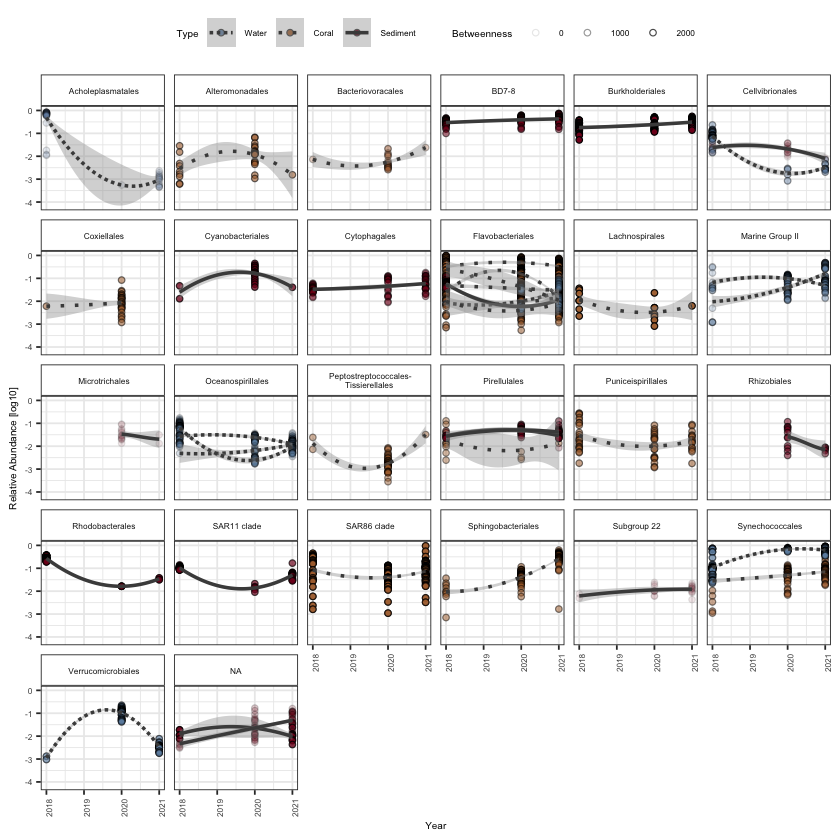

In [266]:
KP_join$KP <- factor(KP_join$KP, levels = c("Water","Coral","Sediment"))
KP_join$Date <- factor(KP_join$Date, levels = c("5/8/18","6/5/18","6/28/18",
                                             "2/11/20", "2/12/20", "2/13/20","2/14/20",
                                              "2/12/21",'2/13/21'))

KP_join %>%
filter(is.numeric(Abundance)) %>%
filter(Abundance >0) %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "o__", replacement = "") %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "_clade", replacement = " clade") %>%
mutate_if(is.character, stringr::str_replace_all, pattern = "Peptostreptococcales-Tissierellales", replacement = "Peptostreptococcales-\nTissierellales") %>%
mutate_if(is.character, stringr::str_replace_all, pattern = "Marine_Group_II", replacement = "Marine Group II") %>%
mutate_if(is.character, stringr::str_replace_all, pattern = "Subgroup_22", replacement = "Subgroup 22") %>%

ggplot(aes(x=Year, y=log10(Abundance))) +

 geom_point(aes(fill=KP, alpha=Betweenness), pch=21) +
  geom_smooth(aes(color=ASVs.y, linetype =KP), method = 'loess', formula = y ~ x, span = 50 ) +

guides(linetype = guide_legend(override.aes = list(color = "#4B4B4B"))) +
  facet_wrap(. ~ Order.y) +
  scale_color_manual(values = rep("#4B4B4B", length(unique(KP_join$ASVs.y)))) +
  scale_fill_manual(values = c("#6F8FAF", "#AD6F3B", "#800020")) +
  scale_linetype_manual(values = c(11, "dotted", "solid")) +
  theme_bw() +
  guides(
    color = "none",
    shape = "none"
  )  +

theme(axis.text.x = element_text(angle = 90, hjust = 1, size=8)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) +
theme(strip.background = element_rect(fill="white")) +
theme(legend.position="top") +


labs(fill='Type') +
labs(linetype='Type') +
ylab("Relative Abundance [log10]")
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Figure6.png",
    width = 6, height = 6, units = "in", dpi=300)

### Relative abundance 

In [192]:

library("data.table")
fast_melt = function(physeq){
  # supports "naked" otu_table as `physeq` input.
  otutab = as(otu_table(physeq), "matrix")
  if(!taxa_are_rows(physeq)){otutab <- t(otutab)}
  otudt = data.table(otutab, keep.rownames = TRUE)
  setnames(otudt, "rn", "taxaID")
  # Enforce character taxaID key
  otudt[, taxaIDchar := as.character(taxaID)]
  otudt[, taxaID := NULL]
  setnames(otudt, "taxaIDchar", "taxaID")
  # Melt count table
  mdt = melt.data.table(otudt, 
                        id.vars = "taxaID",
                        variable.name = "SampleID",
                        value.name = "count")
  # Remove zeroes, NAs
  mdt <- mdt[count > 0][!is.na(count)]
  # Calculate relative abundance
  mdt[, RelativeAbundance := count / sum(count), by = SampleID]
  if(!is.null(tax_table(physeq, errorIfNULL = FALSE))){
    # If there is a tax_table, join with it. Otherwise, skip this join.
    taxdt = data.table(as(tax_table(physeq, errorIfNULL = TRUE), "matrix"), keep.rownames = TRUE)
    setnames(taxdt, "rn", "taxaID")
    # Enforce character taxaID key
    taxdt[, taxaIDchar := as.character(taxaID)]
    taxdt[, taxaID := NULL]
    setnames(taxdt, "taxaIDchar", "taxaID")
    # Join with tax table
    setkey(taxdt, "taxaID")
    setkey(mdt, "taxaID")
    mdt <- taxdt[mdt]
  }
  return(mdt)
}

summarize_taxa = function(physeq, Rank, GroupBy = NULL){
  Rank <- Rank[1]
  if(!Rank %in% rank_names(physeq)){
    message("The argument to `Rank` was:\n", Rank,
            "\nBut it was not found among taxonomic ranks:\n",
            paste0(rank_names(physeq), collapse = ", "), "\n",
            "Please check the list shown above and try again.")
  }
  if(!is.null(GroupBy)){
    GroupBy <- GroupBy[1]
    if(!GroupBy %in% sample_variables(physeq)){
      message("The argument to `GroupBy` was:\n", GroupBy,
              "\nBut it was not found among sample variables:\n",
              paste0(sample_variables(physeq), collapse = ", "), "\n",
              "Please check the list shown above and try again.")
    }
  }
  # Start with fast melt
  mdt = fast_melt(physeq)
  if(!is.null(GroupBy)){
    # Add the variable indicated in `GroupBy`, if provided.
    sdt = data.table(SampleID = sample_names(physeq),
                     var1 = get_variable(physeq, GroupBy))
    setnames(sdt, "var1", GroupBy)
    # Join
    setkey(sdt, SampleID)
    setkey(mdt, SampleID)
    mdt <- sdt[mdt]
  }
  # Summarize
Nsamples = nsamples(physeq)
  summarydt = mdt[, list(meanRA = (mean(RelativeAbundance))*100,
                         sdRA = sd(RelativeAbundance)*100,
                         minRA = min(RelativeAbundance)*100,
                         maxRA = max(RelativeAbundance)*100),
                  by = c(Rank, GroupBy)]
  return(summarydt)
}

In [207]:
ps_AH_kp %>%
summarize_taxa(Rank="Order", GroupBy="Site.Status") %>%
filter(Order %in% c(' o__Coxiellales')) %>%
arrange(-meanRA) 

Order,Site.Status,meanRA,sdRA,minRA,maxRA
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
o__Coxiellales,Epidemic,1.2875227,1.51534,0.1179878,8.3841092
o__Coxiellales,Vulnerable,0.6079027,NA,0.6079027,0.6079027


In [209]:
ps_sed_kp %>%
summarize_taxa(Rank="Order", GroupBy="Site.Status") %>%
#filter(Order %in% c(' o__Rhizobiales')) %>%
arrange(-meanRA) 

Order,Site.Status,meanRA,sdRA,minRA,maxRA
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
o__BD7-8,Endemic,45.9550024,1.605770e+01,14.9643705,73.8080869
o__BD7-8,Epidemic,41.5644045,1.317272e+01,15.0602410,62.5000000
o__Burkholderiales,Endemic,32.4449359,1.002042e+01,13.8676845,55.1068884
o__BD7-8,Vulnerable,31.1255731,9.519540e+00,9.9212598,47.2513089
o__Burkholderiales,Epidemic,27.3435486,1.363315e+01,11.5347950,51.1111111
o__Rhodobacterales,Vulnerable,27.2857789,5.316199e+00,19.0769231,37.8378378
o__Burkholderiales,Vulnerable,19.8769392,8.796193e+00,5.1643192,38.2222222
o__Cyanobacteriales,Epidemic,19.6418154,1.123229e+01,4.1379310,44.6139180
o__SAR11_clade,Vulnerable,10.4288857,1.409418e+00,8.4935897,14.0298507


In [208]:
ps_wat_kp %>%
summarize_taxa(Rank="Order", GroupBy="Site.Status") %>%
filter(Order %in% c(' o__Verrucomicrobiales')) %>%
arrange(-meanRA) 

Order,Site.Status,meanRA,sdRA,minRA,maxRA
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
o__Verrucomicrobiales,Epidemic,11.4478369,4.91183324,4.20168067,22.2639520
o__Verrucomicrobiales,Endemic,0.3567656,0.13559995,0.18075640,0.7697947
o__Verrucomicrobiales,Vulnerable,0.1139271,0.02597055,0.09556314,0.1322910


In [16]:
R.version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          4.1                         
year           2024                        
month          06                          
day            14                          
svn rev        86737                       
language       R                           
version.string R version 4.4.1 (2024-06-14)
nickname       Race for Your Life          